In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


In [81]:
data = pd.read_csv('./AAPL_5yr.csv')
print(data.shape)
print(data.sample(7))

data.info()
data['Date'] = pd.to_datetime(data['Date'])

(250, 7)
           Date        Open        High         Low       Close   Adj Close  \
154  2022-11-04  142.089996  142.669998  134.380005  138.380005  138.169037   
26   2022-05-04  159.669998  166.479996  159.259995  166.020004  165.020370   
230  2023-02-27  147.710007  149.169998  147.449997  147.919998  147.919998   
29   2022-05-09  154.929993  155.830002  151.490005  152.059998  151.366486   
105  2022-08-26  170.570007  171.050003  163.559998  163.619995  163.100006   
73   2022-07-13  142.990005  146.449997  142.119995  145.490005  144.826447   
146  2022-10-25  150.089996  152.490005  149.360001  152.339996  151.855850   

        Volume  
154  140814800  
26   108256500  
230   44998500  
29   131577900  
105   78961000  
73    71185600  
146   74732300  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       250 non-null    object

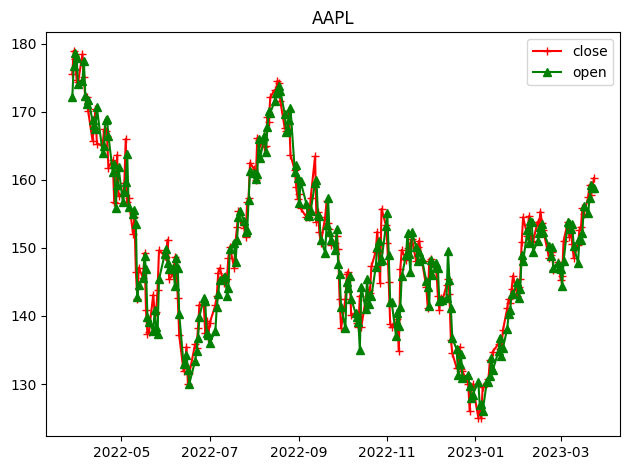

In [82]:
plt.figure()
plt.plot(data['Date'], data['Close'], c="r", label="close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()


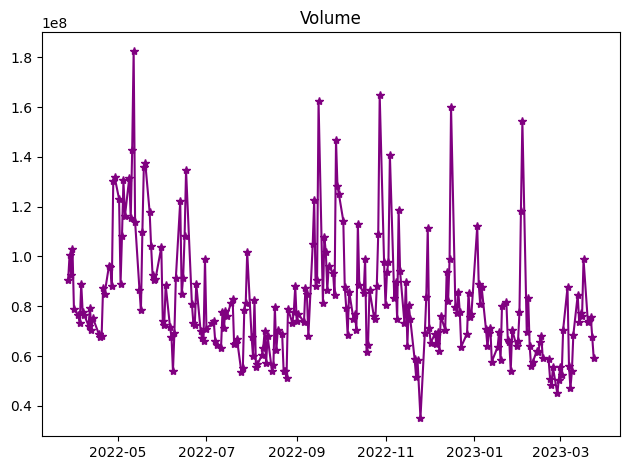

In [83]:

plt.figure()
plt.plot(data['Date'], data['Volume'], c='purple', marker='*')
plt.title("Volume")
plt.tight_layout()

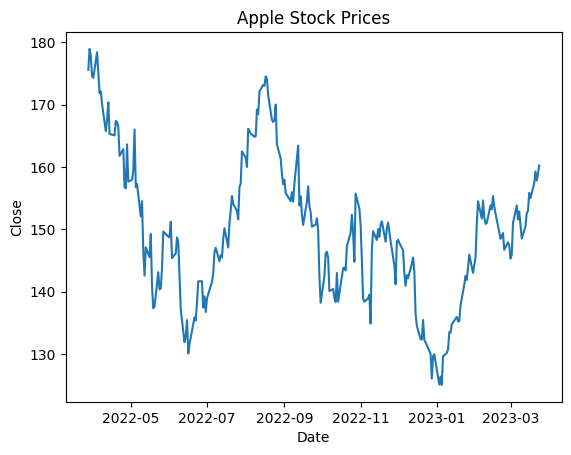

In [84]:
prediction_range = data.loc[(data['Date'] > datetime(2018,3,27)) & (data['Date'] < datetime(2023,3,27))]
plt.plot(data['Date'], data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

In [85]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

238


In [86]:

from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
  
train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []
  
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [87]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

2023-03-27 23:18:34.656088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 23:18:34.657905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 23:18:34.658705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fd6d33b8d60>>

In [88]:

model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10


2023-03-27 23:18:35.063162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 23:18:35.065198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 23:18:35.066169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 3s 68ms/step - loss: 0.0996
Epoch 2/10
6/6 [==============================] - 0s 65ms/step - loss: 0.0348
Epoch 3/10
6/6 [==============================] - 0s 66ms/step - loss: 0.0332
Epoch 4/10
6/6 [==============================] - 0s 64ms/step - loss: 0.0303
Epoch 5/10
6/6 [==============================] - 0s 62ms/step - loss: 0.0262
Epoch 6/10
6/6 [==============================] - 0s 61ms/step - loss: 0.0231
Epoch 7/10
6/6 [==============================] - 0s 60ms/step - loss: 0.0223
Epoch 8/10
6/6 [==============================] - 0s 59ms/step - loss: 0.0192
Epoch 9/10
6/6 [==============================] - 0s 60ms/step - loss: 0.0209
Epoch 10/10
6/6 [==============================] - 0s 63ms/step - loss: 0.0158


In [89]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
  
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2023-03-27 23:18:41.404966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 23:18:41.406718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 23:18:41.407828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 465ms/step
MSE 25.882293194859574
RMSE 5.087464318779992


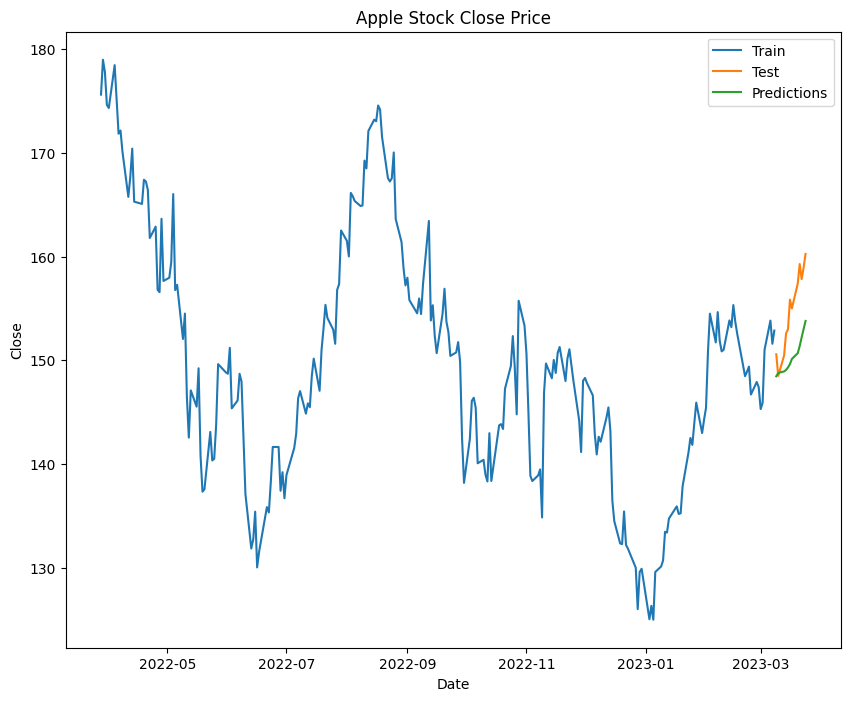

In [90]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions
  
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
# plt.axis([2022,2023,120,180])